<a href="https://colab.research.google.com/github/gorogoro-uk/Machine-Learning/blob/master/K_Means_example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Example: K Means Clustering Pipeline

**TGCA Pan-Cancer Gene Expression Data**

Use MinMaxScaler to preprocess data. 

Use PCA to reduce to 2 feature dimensions.

Use K means clustering.

Compare with known label.

In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# get data from UCI
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve(full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

print("download, extract complete")

# prepare data files
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

# Features: generate numpy array from txt file
data = np.genfromtxt(
     datafile,
     delimiter=",",
     usecols=range(1, 20532),
     skip_header=1)

print("feature dataset complete")

# Labels: generate from txt file (in this case there are known correct cluster labels)
true_label_names = np.genfromtxt(
     labels_file,
     delimiter=",",
     usecols=(1,),
     skip_header=1,
     dtype="str")

print("label dataset complete")

download, extract complete
feature dataset complete
label dataset complete


In [6]:
# inspect data & true labels
print(data[:5, :3])
print(true_label_names[:5])

[[0.         2.01720929 3.26552691]
 [0.         0.59273209 1.58842082]
 [0.         3.51175898 4.32719872]
 [0.         3.66361787 4.50764878]
 [0.         2.65574107 2.82154696]]
['PRAD' 'LUAD' 'PRAD' 'PRAD' 'BRCA']


In [3]:
# encode labels with integer values
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0])

In [10]:
# inspect label class names used by encoder
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

In [4]:
# true number of clusters 
n_clusters = len(label_encoder.classes_)

In [5]:
# Data preprocessing
# Use MinMaxScaler, standardise values between 0 and 1
# Use PCA, retain top two dimensions
preprocessor = Pipeline([("scaler", MinMaxScaler()),
                         ("pca", PCA(n_components=2, random_state=42)),])

In [6]:
# K Means clustering pipeline
clusterer = Pipeline([("kmeans",
              KMeans(n_clusters=n_clusters,
              init="k-means++",    # use best initialisation
              n_init=50,           # number of trials to work out best SSE
              max_iter=500,        # max number of iterations
              random_state=42,),),])

In [7]:
# define full pipeline: pre-processing & clusterming
pipe = Pipeline([("preprocessor", preprocessor),
                 ("clusterer", clusterer)])

In [ ]:
# fit data
pipe.fit(data)

In [ ]:
# pre-process data
preprocessed_data = pipe["preprocessor"].transform(data)

# inspect predicted cluster labels
predicted_labels = pipe["clusterer"]["kmeans"].labels_

# inspect silhouette score to assess best K
silhouette_score(preprocessed_data, predicted_labels)

In [ ]:
# 
adjusted_rand_score(true_labels, predicted_labels)

In [11]:
# put in dataframe
pcadf = pd.DataFrame(pipe["preprocessor"].transform(data),
                    columns=["component_1", "component_2"],
)
# add predicted cluster label to df
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

# add true cluster label column to df
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

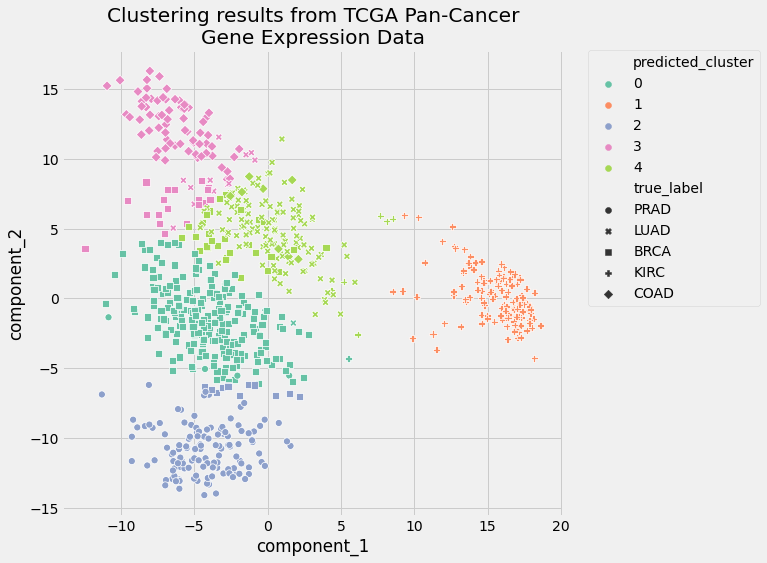

In [12]:
# visualise results
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
     "component_1",
     "component_2",
     s=50,
     data=pcadf,
     hue="predicted_cluster",
     style="true_label",
     palette="Set2",
)

scat.set_title("Clustering results from TCGA Pan-Cancer\nGene Expression Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()